In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import seaborn as sns
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

In [30]:
# 1. Load data
df = pd.read_csv("OSBS_datasets/Cleaned_data/cleaned_30min_final_data_V3.csv", parse_dates=["datetime"])

In [31]:
df.head()

,datetime,soilCO2concentrationMean,soilTempMean,VSWCMean,VSICMean,windSpeedMean,windDirMean,RHMean,tempRHMean,dewTempMean,...,TFPrecip_flag,VPD,soilTempMean_lag1h,soilTempMean_lag2h,VSWCMean_lag1h,VSWCMean_lag2h,soilCO2concentrationMean_lag1h,soilCO2concentrationMean_lag2h,VPD_lag1h,VPD_lag2h
0,2021-01-01 00:00:00+00:00,1523.192667,16.923000,0.072140,965.912500,0.207000,106.407000,81.251667,21.704133,18.301500,...,0.0,0.486824,21.172000,21.170725,0.056803,0.056799,1618.358988,1617.897607,0.654388,0.654530
1,2021-01-01 00:30:00+00:00,1522.119667,16.949433,0.072170,965.468533,0.224667,138.101333,84.152000,21.363967,18.530300,...,0.0,0.403039,21.172000,21.170725,0.056803,0.056799,1618.358988,1617.897607,0.654388,0.654530
2,2021-01-01 01:00:00+00:00,1515.906000,16.975733,0.072480,964.494233,0.283500,102.852500,85.827333,21.361033,18.842533,...,0.0,0.360368,16.923000,21.170725,0.072140,0.056799,1523.192667,1617.897607,0.486824,0.654530
3,2021-01-01 01:30:00+00:00,1498.878000,17.002767,0.072167,965.737833,0.388000,134.620833,86.222667,21.620167,19.170733,...,0.0,0.355915,16.949433,21.170725,0.072170,0.056799,1522.119667,1617.897607,0.403039,0.654530
4,2021-01-01 02:00:00+00:00,1475.510333,17.029633,0.072253,964.854900,0.295167,127.154000,88.225333,21.397933,19.320833,...,0.0,0.300071,16.975733,16.923000,0.072480,0.072140,1515.906000,1523.192667,0.360368,0.486824


In [38]:
# 1. Define feature groups
main_features = [
    'VSWCMean', 'soilTempMean', 'soilCO2concentrationMean', 'RHMean',
    'windSpeedMean', 'windDirMean', 'TFPrecip_flag', 'VPD', 'VSICMean', 'tempRHMean', 'dewTempMean'
]
min_features = [f for f in df.columns if 'Minimum' in f]
max_features = [f for f in df.columns if 'Maximum' in f]
var_features = [f for f in df.columns if 'Variance' in f or 'Var' in f]
other_features = [col for col in df.columns 
              if all(x not in col for x in ['Mean', 'Minimum', 'Maximum', 'Variance','flag','datetime'])]
all_features = main_features + min_features + max_features + var_features + other_features

# 2. Normalize features
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[all_features] = scaler.fit_transform(df[all_features])

In [40]:
# 3. Assign weights to mean features only
weights_dict = {
    'VSWCMean': 0.25,
    'soilTempMean': 0.15,
    'soilCO2concentrationMean': 0.10,
    'RHMean': 0.20,
    'VPD': 0.05,
    'TFPrecip_flag': 0.10,
    'windSpeedMean': 0.10,
    'windDirMean': 0.05,
    'VSICMean': 0.03,
    'tempRHMean': 0.015,
    'dewTempMean': 0.015
}

# Normalize weights so sum = 1
total_weight = sum(weights_dict.values())
weights_dict_normalized = {k: v/total_weight for k, v in weights_dict.items()}

# Compute risk_score using only mean features
weights = [weights_dict_normalized[f] for f in main_features]
df_scaled['risk_score'] = (df_scaled[main_features] * weights).sum(axis=1)

# 4. Apply KMeans clustering using all features
kmeans = KMeans(n_clusters=3, random_state=42)
df_scaled['risk_cluster_kmeans'] = kmeans.fit_predict(df_scaled[all_features])

# 5. Label clusters as Low/Medium/High based on average risk_score
cluster_avg = df_scaled.groupby('risk_cluster_kmeans')['risk_score'].mean().sort_values()
risk_label_map = {cluster: label for cluster, label in zip(cluster_avg.index, ['Low','Medium','High'])}
df_scaled['risk_label'] = df_scaled['risk_cluster_kmeans'].map(risk_label_map)

# 6. Inspect results
print("Cluster counts:")
df_scaled['risk_label'].value_counts()



# Check




Cluster counts:


risk_label
Low       4576
Medium    2765
High      1272
Name: count, dtype: int64

In [41]:
print("\nCluster summary (feature means + risk_score):")
cluster_summary = df_scaled.groupby('risk_label')[all_features + ['risk_score']].mean()
cluster_summary



Cluster summary (feature means + risk_score):


,VSWCMean,soilTempMean,soilCO2concentrationMean,RHMean,windSpeedMean,windDirMean,TFPrecip_flag,VPD,VSICMean,tempRHMean,...,RHVariance,tempRHVariance,dewTempVariance,TFPrecipBulk,wind_sin,wind_cos,VPD,VPD_lag1h,VPD_lag2h,risk_score
risk_label,,,,,,,,,,,,,,,,,,,,,
High,0.304458,0.556369,0.967556,0.752341,0.171296,0.480024,0.028695,0.210654,0.722380,0.745487,...,0.002124,0.001876,0.002281,0.009629,0.501323,0.379467,0.210654,0.211136,0.210752,0.478458
Low,0.204453,0.283458,0.261856,0.556515,0.302359,0.473913,0.004953,0.292592,0.635587,0.624167,...,0.001333,0.000928,0.001806,0.001830,0.505125,0.482893,0.292592,0.288627,0.282298,0.318700
Medium,0.289944,0.151865,0.183253,0.786837,0.227357,0.509161,0.010127,0.086588,0.869955,0.400030,...,0.000887,0.000222,0.000497,0.003318,0.459989,0.580810,0.086588,0.093081,0.103858,0.343839


In [62]:
# Map string risk labels to numeric labels directly
label_numeric_map = {'Low': 0, 'Medium': 1, 'High': 2}
df_scaled['risk_label_numeric'] = df_scaled['risk_label'].map(label_numeric_map)


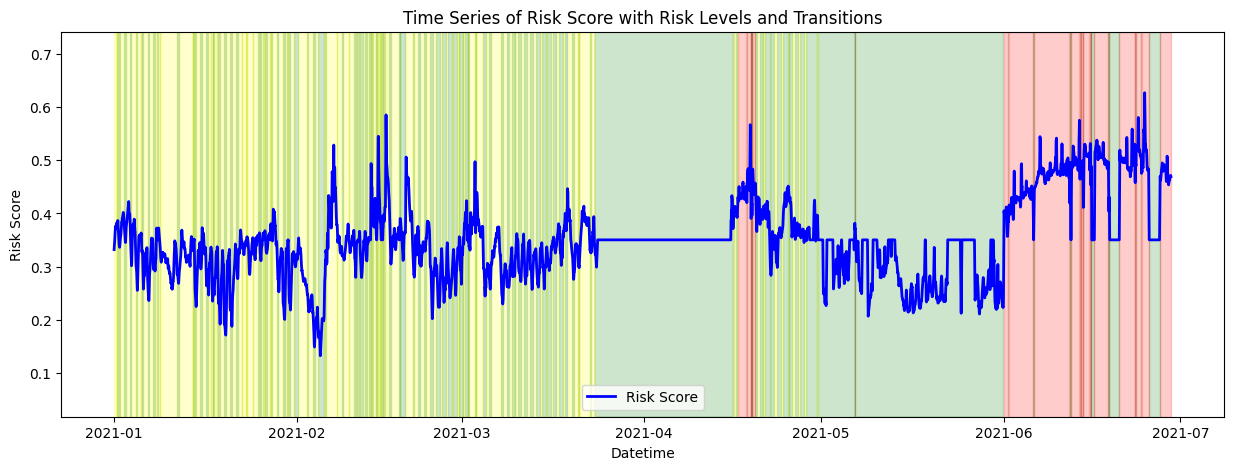

In [63]:

# Smooth the risk_score with a rolling window (adjust window as needed)
df_scaled['risk_score_smooth'] = df_scaled['risk_score'].rolling(window=5, min_periods=1).mean()

# Map risk_label to colors
color_map = {'Low': 'green', 'Medium': 'yellow', 'High': 'red'}
df_scaled['risk_color'] = df_scaled['risk_label'].map(color_map)

plt.figure(figsize=(15,5))

# Plot smoothed risk_score
plt.plot(df_scaled['datetime'], df_scaled['risk_score_smooth'], color='blue', label='Risk Score', linewidth=2)

# Shade background according to risk_label
for label, color in color_map.items():
    mask = df_scaled['risk_label'] == label
    plt.fill_between(df_scaled['datetime'], 0, 1, where=mask,
                     color=color, alpha=0.2, transform=plt.gca().get_xaxis_transform())

# Highlight transitions with vertical lines
risk_changes = df_scaled['risk_label'].ne(df_scaled['risk_label'].shift())
change_points = df_scaled.loc[risk_changes, 'datetime']


plt.xlabel('Datetime')
plt.ylabel('Risk Score')
plt.title('Time Series of Risk Score with Risk Levels and Transitions')
plt.legend()
plt.show()


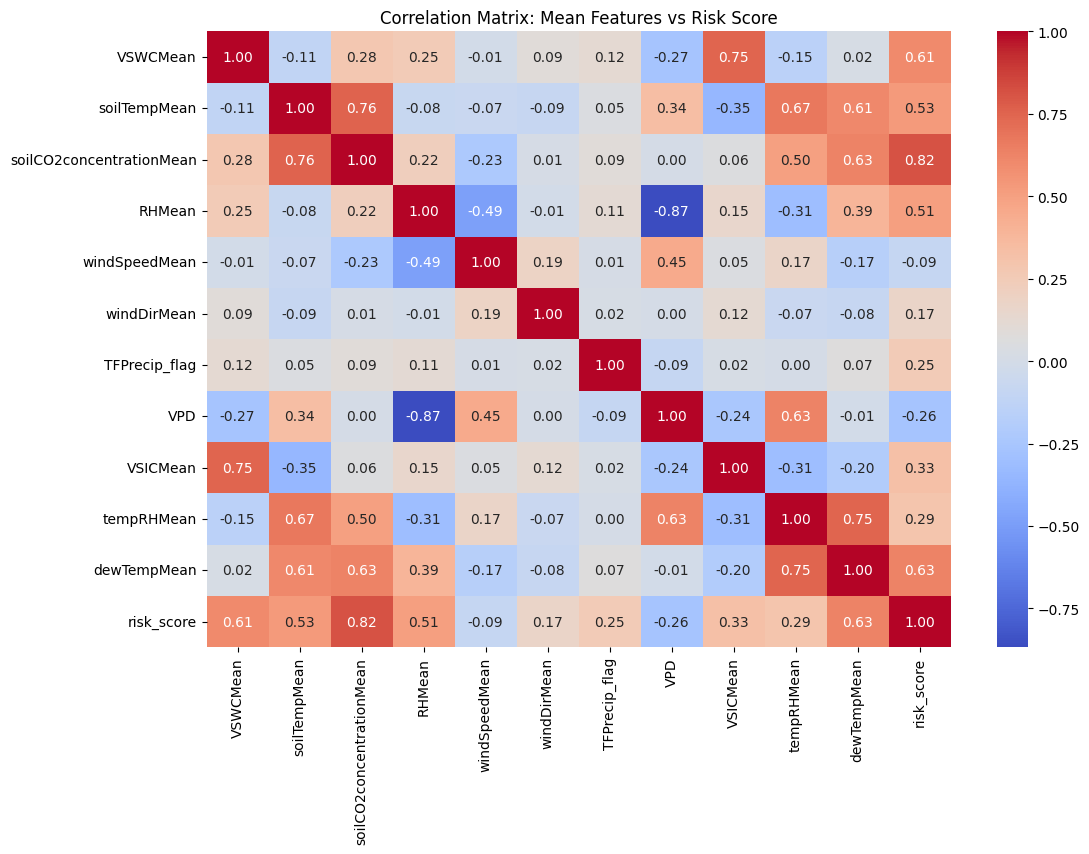

In [71]:
# Select only mean features + risk_score
corr_features = main_features + ['risk_score']

# Compute correlation matrix
corr_matrix = df_scaled[corr_features].corr()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix: Mean Features vs Risk Score")
plt.show()

In [72]:
corr_matrix

,VSWCMean,soilTempMean,soilCO2concentrationMean,RHMean,windSpeedMean,windDirMean,TFPrecip_flag,VPD,VSICMean,tempRHMean,dewTempMean,risk_score
VSWCMean,1.000000,-0.110762,0.279470,0.249554,-0.009172,0.094440,0.117079,-0.266287,0.748006,-0.151892,0.020987,0.605775
soilTempMean,-0.110762,1.000000,0.756840,-0.079174,-0.070338,-0.085077,0.045433,0.337574,-0.353245,0.674006,0.606769,0.527481
soilCO2concentrationMean,0.279470,0.756840,1.000000,0.219356,-0.227901,0.009392,0.091716,0.000359,0.055663,0.498437,0.633272,0.816136
RHMean,0.249554,-0.079174,0.219356,1.000000,-0.485962,-0.011925,0.111410,-0.868078,0.148109,-0.309853,0.390492,0.508381
windSpeedMean,-0.009172,-0.070338,-0.227901,-0.485962,1.000000,0.188388,0.010307,0.452241,0.047524,0.169452,-0.170704,-0.091791
windDirMean,0.094440,-0.085077,0.009392,-0.011925,0.188388,1.000000,0.021342,0.002915,0.118218,-0.068559,-0.080059,0.172889
TFPrecip_flag,0.117079,0.045433,0.091716,0.111410,0.010307,0.021342,1.000000,-0.088749,0.015788,0.003692,0.073180,0.254042
VPD,-0.266287,0.337574,0.000359,-0.868078,0.452241,0.002915,-0.088749,1.000000,-0.243052,0.628097,-0.008092,-0.262582
VSICMean,0.748006,-0.353245,0.055663,0.148109,0.047524,0.118218,0.015788,-0.243052,1.000000,-0.307624,-0.199936,0.327075
tempRHMean,-0.151892,0.674006,0.498437,-0.309853,0.169452,-0.068559,0.003692,0.628097,-0.307624,1.000000,0.747456,0.292929


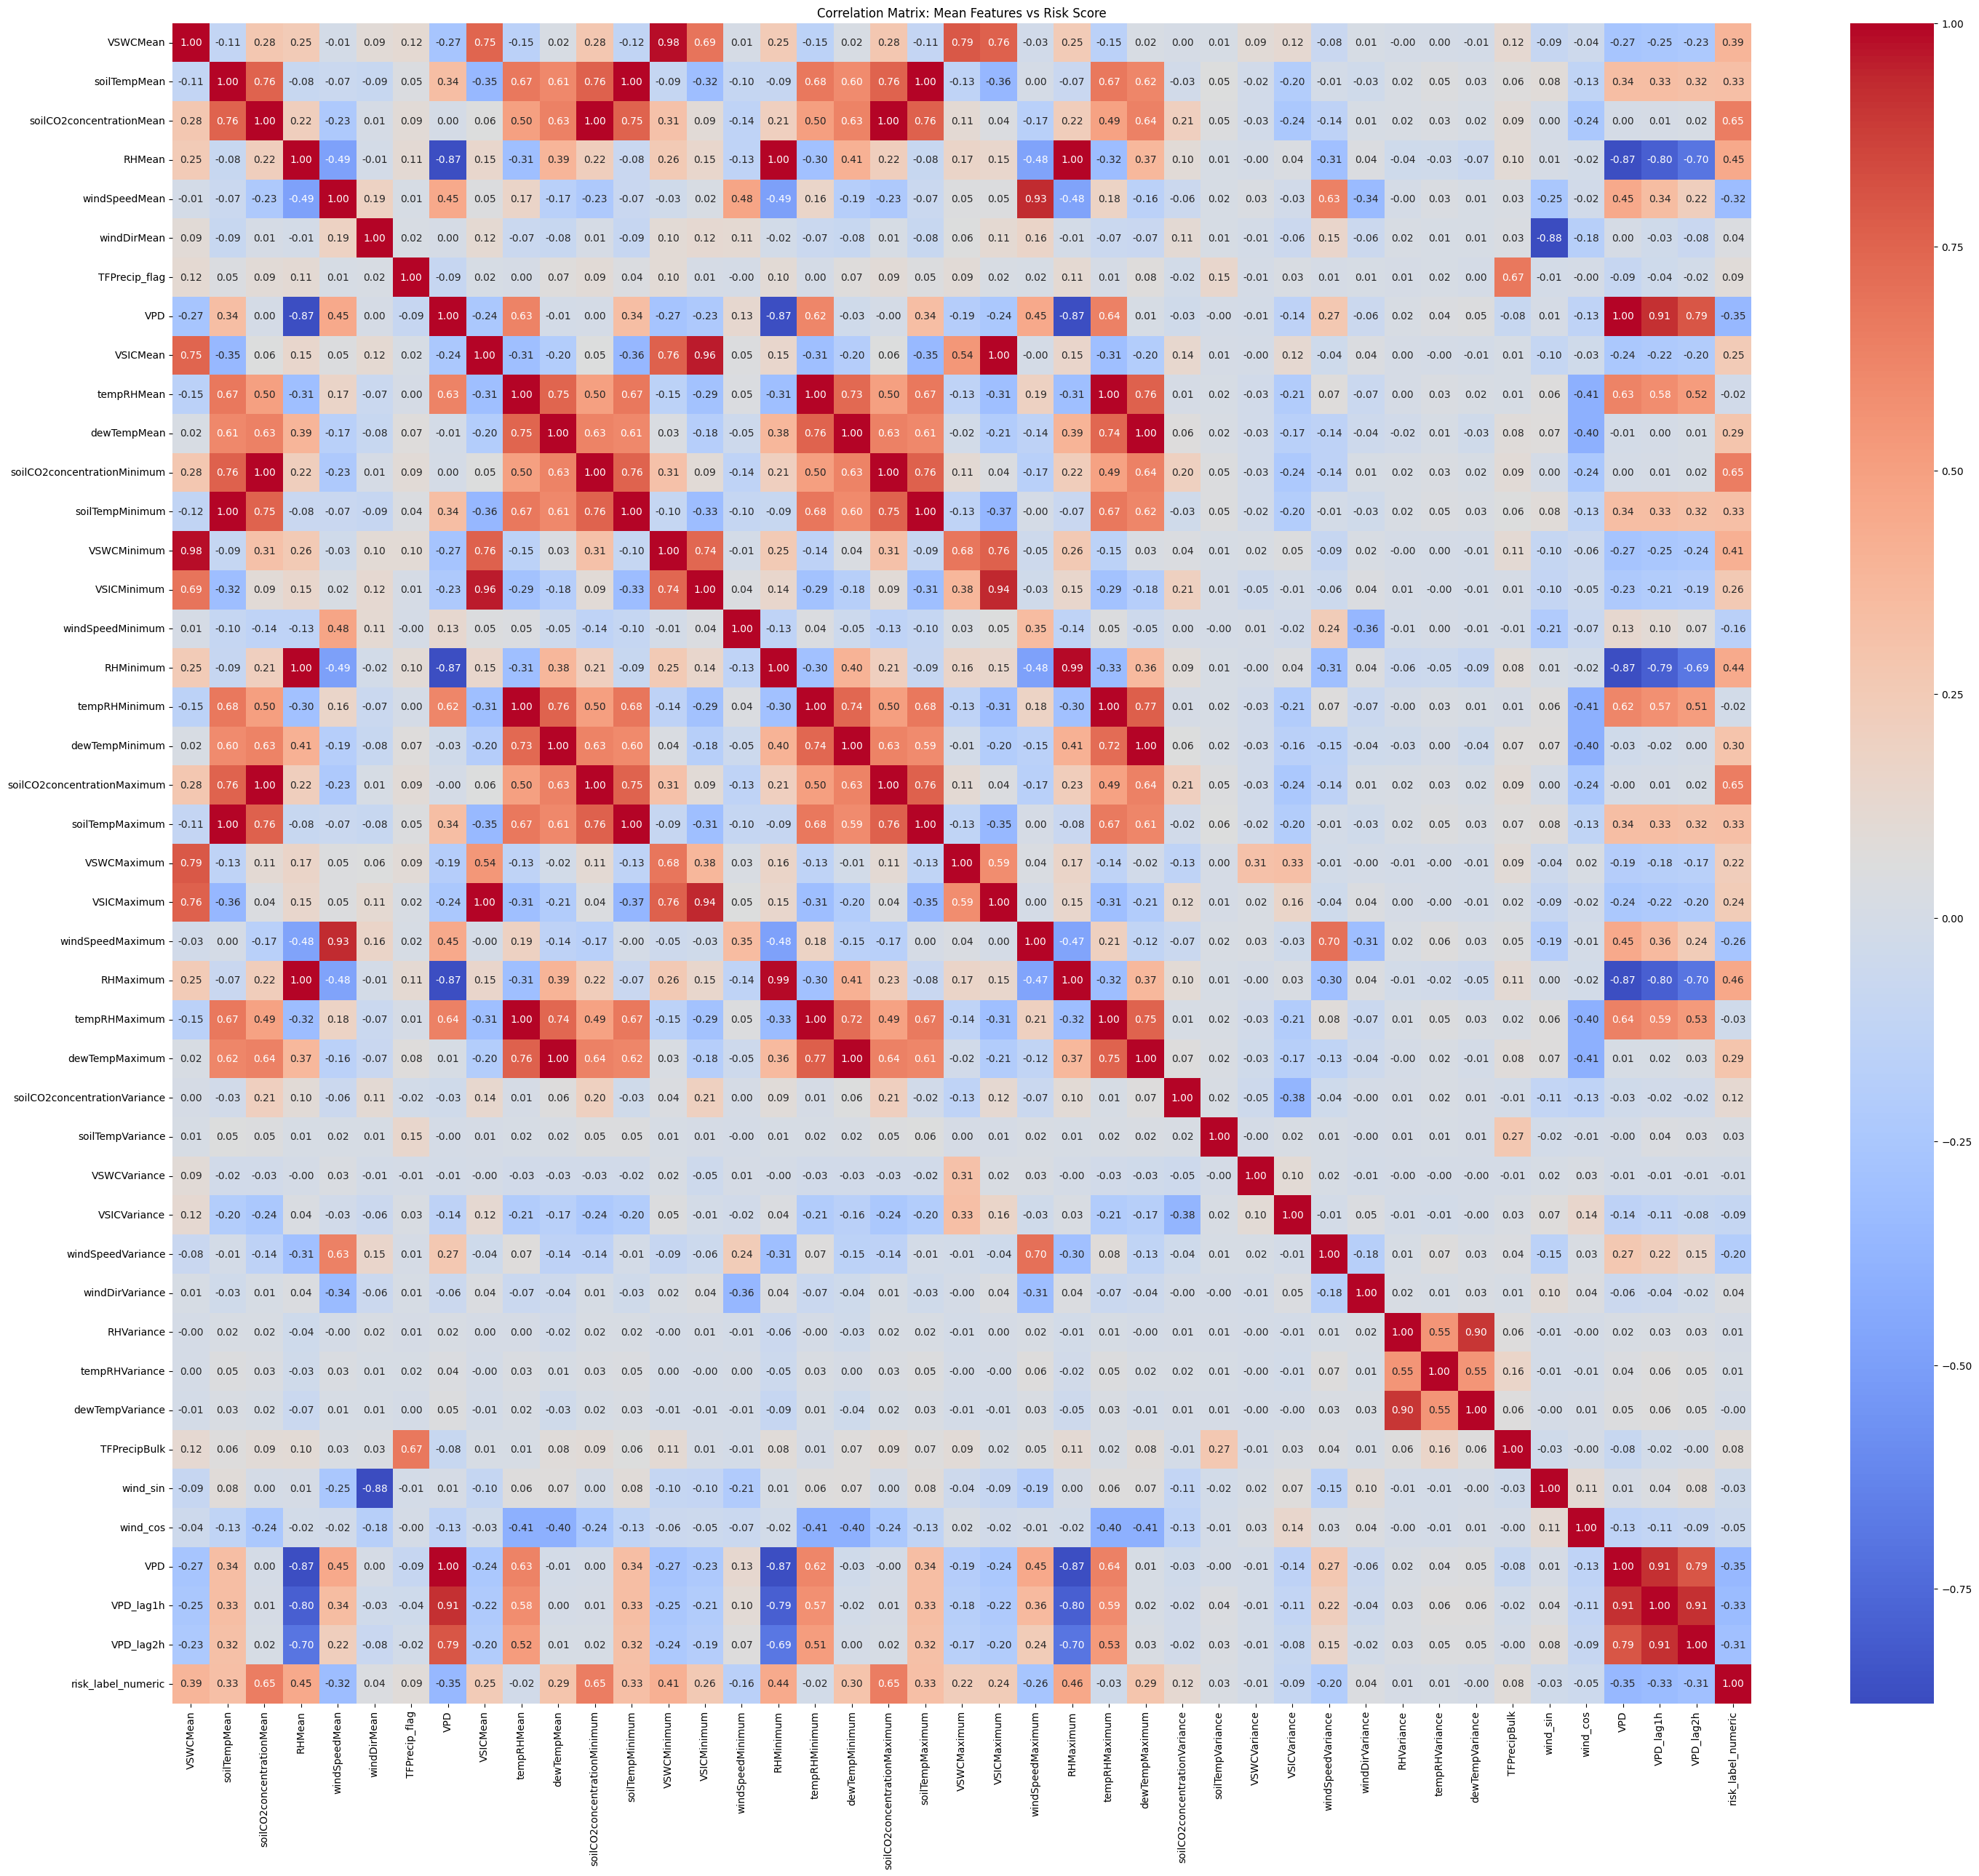

In [67]:
# Select only mean features + risk_score
corr_features = all_features + ['risk_label_numeric']

# Compute correlation matrix
corr_matrix = df_scaled[corr_features].corr()

# Plot heatmap
plt.figure(figsize=(35,30))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix: Mean Features vs Risk Score")
plt.show()

In [73]:
df_scaled.head(20)

,datetime,soilCO2concentrationMean,soilTempMean,VSWCMean,VSICMean,windSpeedMean,windDirMean,RHMean,tempRHMean,dewTempMean,...,soilCO2concentrationMean_lag1h,soilCO2concentrationMean_lag2h,VPD_lag1h,VPD_lag2h,risk_score,risk_cluster_kmeans,risk_label,risk_score_smooth,risk_color,risk_label_numeric
0,2021-01-01 00:00:00+00:00,0.299223,0.088423,0.325289,0.902598,0.092867,0.290993,0.734034,0.653252,0.770777,...,1618.358988,1617.897607,0.214407,0.214448,0.331993,0,Medium,0.331993,yellow,1
1,2021-01-01 00:30:00+00:00,0.298756,0.089624,0.325443,0.901819,0.102881,0.381632,0.768125,0.643298,0.777991,...,1618.358988,1617.897607,0.214407,0.214448,0.342616,0,Medium,0.337304,yellow,1
2,2021-01-01 01:00:00+00:00,0.296051,0.090818,0.327032,0.900109,0.136231,0.280828,0.787818,0.643212,0.787834,...,1523.192667,1617.897607,0.166462,0.214448,0.344525,0,Medium,0.339711,yellow,1
3,2021-01-01 01:30:00+00:00,0.288640,0.092047,0.325426,0.902292,0.195465,0.371678,0.792465,0.650795,0.798181,...,1522.119667,1617.897607,0.142489,0.214448,0.354627,0,Medium,0.343440,yellow,1
4,2021-01-01 02:00:00+00:00,0.278470,0.093267,0.325870,0.900742,0.142844,0.350325,0.816005,0.644292,0.802913,...,1515.906000,1523.192667,0.130279,0.166462,0.351592,0,Medium,0.345071,yellow,1
5,2021-01-01 02:30:00+00:00,0.273353,0.094541,0.327374,0.899447,0.215399,0.323198,0.843686,0.636776,0.808292,...,1498.878000,1522.119667,0.129005,0.142489,0.361505,0,Medium,0.350973,yellow,1
6,2021-01-01 03:00:00+00:00,0.272492,0.095769,0.327049,0.898224,0.231838,0.368096,0.866255,0.632474,0.814361,...,1475.510333,1515.906000,0.113027,0.130279,0.368765,0,Medium,0.356203,yellow,1
7,2021-01-01 03:30:00+00:00,0.268591,0.096959,0.327118,0.897884,0.253188,0.350520,0.866686,0.634825,0.817078,...,1463.754667,1498.878000,0.094781,0.129005,0.369911,0,Medium,0.361280,yellow,1
8,2021-01-01 04:00:00+00:00,0.263757,0.098150,0.327648,0.896287,0.257440,0.429001,0.863250,0.633530,0.814088,...,1461.775667,1475.510333,0.080516,0.113027,0.373188,0,Medium,0.364992,yellow,1
9,2021-01-01 04:30:00+00:00,0.260758,0.099282,0.327562,0.896445,0.233916,0.396502,0.869789,0.629807,0.813181,...,1452.813667,1463.754667,0.080518,0.094781,0.370260,0,Medium,0.368726,yellow,1
